# CUWALID MODEL TRAINING

## Simulating Hydrology from a Seasonal Forecast

#### Contents

The following course cover the following content:

* Convert climate seasonal forecasting into model forcing datasets
* **Translate climate forecasting into hydrological forecasting**


### 4. Translate climate forecasting into hydrological forecasting

1. Creating an ensamble of model simulation files
* Runing multiple simulaiton
* Understanding seasonal hydrological forecasting

**WARNING!**. Before you start the analyis, please make sure that you directories have the following structure.

In [11]:
print("Local_directory\n|__training\n      |___forecast\n      |      |__regional\n      |      |     |__datasets\n      |      |     |    |__csv\n      |      |     |    |__shp\n      |      |     |__model\n      |      |     |    |__inputs\n      |      |     |__outputs\n      |      |     |__postpp\n      |      |          |__csv\n      |      |          |__netcdf\n      |      |          |__raster\n      |      |          |__fig\n      |	     |__basin\n      |___historical\n             |__regional\n             |     |__datasets\n             |     |__model\n             |     |__outputs\n             |     |__postpp\n       	     |__basin\n")

Local_directory
|__training
      |___forecast
      |      |__regional
      |      |     |__datasets
      |      |     |    |__csv
      |      |     |    |__shp
      |      |     |__model
      |      |     |    |__inputs
      |      |     |__outputs
      |      |     |__postpp
      |      |          |__csv
      |      |          |__netcdf
      |      |          |__raster
      |      |          |__fig
      |	     |__basin
      |___historical
             |__regional
             |     |__datasets
             |     |__model
             |     |__outputs
             |     |__postpp
       	     |__basin



### 4.1. Create an ensamble of model simulation files

The first step for runing the hydrological model is the creation on all input and setting files for each of the realizations. All model files can be created using creating simple text editors (e.g. notepad in windows). Example of model files are found on the folder training/historical/regional/model/.

A detailed description of all model files can be found in DRYP documentation as well as in the DRYP folder of the present tranining material.


For running all simulations, we have preparing all the input files by copying and changing the required fields on the each file. The script below can be used to create all simulation model files.

In [12]:
import os
import numpy as np
import pandas as pd

def write_dryp_sim_file_forecasting(fname_input, newfname_input=None, mname="sim",
									dataset_pre="YYYYMM", dataset_pet="YYYYMM",
								start_date="2024 03 01", end_date="2024 05 31",
								create_setting_file=True):
	""" This function create the simulation and setting file for runnig DRYP. New
	files are created  based on files provided as original files, this function
	changes the model name, precipitation and potential evapotranspiration
	paths.
	WARNING: if no new filename is provided it will replace the original file
	
	Parameters:
	-----------
	fname_input : string
			model inputfile, including path
	newfname : string
			new model inputfile, including path
	mname : string
			model name for the new file
	dataset_pre : string
			precipitation dataset name, including path
	dataset_pet : string
			potential evapotranspiration dataset name, including path
	start_date : string
			date in the following format "YYYY-MM-DD" (e.g. 2002-01-01)
	end_date : string
			date in the following format "YYYY-MM-DD" (e.g. 2002-03-01)
	create_setting_file : bool
			If True it create the setting dryp file
	"""

	# Check if input file exist
	if not os.path.exists(fname_input):
		raise ValueError("File not availble")
	
	# Read model input file
	f = pd.read_csv(fname_input)
	
	# Change model name by adding the simulation number
	f.drylandmodel[1] = mname

	# Meterological data ==============================================
	f.drylandmodel[66] = dataset_pre	# Precipitation file
	f.drylandmodel[68] = dataset_pet	# Evapotranspiration file
	
	# create simulation paramter files
	if create_setting_file is True:
		# change parameters of the of the setting parameter file
		fname_settings = f.drylandmodel[87]
	
		# create a copy of the file with the new name
		fname_root = fname_settings.split('.')[0]
		fname_ext = fname_settings.split('.')[1]
			
		# replace new setting file
		f.drylandmodel[87] = newfname_settings
	
		# Open setting parameter file
		fsimpar = pd.read_csv(fname_settings)
		
		# change simulation period
		fsimpar.DWAPM_SET[2] = start_date
		fsimpar.DWAPM_SET[4] = end_date
		
		# new input file name
		newfname_settings = fname_root+'_'+sim+'.'+fname_ext
		copyfile(fname_settings, newfname_settings)
	
		# Reeplace model input and parameters file
		os.remove(newfname_settings) if os.path.exists(newfname_settings) else None
		
		# Reeplace model input and parameters file
		fsimpar.to_csv(newfname_settings, index=False)
		
	# Reeplace model input and parameters file
	os.remove(newfname_input) if os.path.exists(newfname_input) else None
	# Write model parameter and input file
	f.to_csv(newfname_input, index=False)

def gen_array_input_files(fname_input, fname_parameter_sets):
	# read parameter sets
	parameter = pd.read_csv(fname_parameter_sets)
	
	#Create a copy of inputfile
	fname_root = fname_input.split('.')[0]
	fname_ext = fname_input.split('.')[1]
	for npar in range(0, 100):
		# new input file name
		newfname_input = fname_root+'_'+str(npar)+'.'+fname_ext
		# replace all new values in dataset
		write_sim_file(fname_input, newfname_input, parameter.loc[npar])

In [13]:
def create_ensamble(pools, nsamples=30):
    """
    Parameters
    -----------
    forecast_pet: path-list for forecasted evapotranspiration
    forecast_pet: path-list for forecasted precipitation
    """
    #print(sorted(glob.glob(f'{forecast_pet}/*_MAM_*.nc')))
    #pools = list(map(lambda x: sorted(glob.glob(f'{x}/*_MAM_*.nc')), [forecast_pet, forecast_pre]))
    #print(pools)
    plist = np.asarray([f'{x}+{y}+' for x in pools[0] for y in pools[1]])
    # the sampling is done here
    #what_ = np.random.default_rng().choice(plist, size=nsamples, replace=False).tolist()
    what_ = np.random.default_rng(seed=42).choice(plist, size=nsamples, replace=False).tolist()
    # returns a list of nsamples-pairs, e.g., [['pet_20', 'pre_1'], ['pet_0', 'pre_29'], [...], ...]
    pairs = list(map(lambda x: x.split('+'), what_))
    return pairs

In [2]:
import matplotlib.pyplot as plt
import rasterio
# this function can be used for ploting raster maps, modify it as your conveniency.
def plot_raster_file(fname, ax=None, vmin=-20.0, vmax=20.0):
    # create plot
    if ax is None:
        fig, ax = plt.subplots()
    cmap = plt.cm.get_cmap('coolwarm_r', 12)
    data = rasterio.open(fname).read(1)
    im = ax.imshow(data,# origin="lower",#cmap=cmap, 
                   vmin=vmin, vmax=vmax,
                   )#extent=bounds)	
    
    ax.axis('off')
    plt.colorbar(im)
    return im

/tmp/ipykernel_1899156/94300322.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm_r', 12)


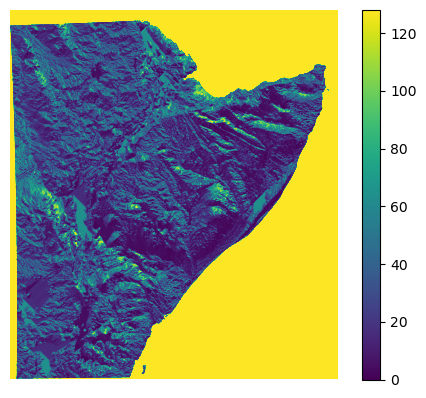

In [10]:
fname_parameter = "/home/cuwalid/training/historical/regional/model/input/HAD_flowdir_D8.asc"
plot_raster_file(fname_parameter, vmin=0.0, vmax=128.0)

/tmp/ipykernel_1899156/94300322.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm_r', 12)


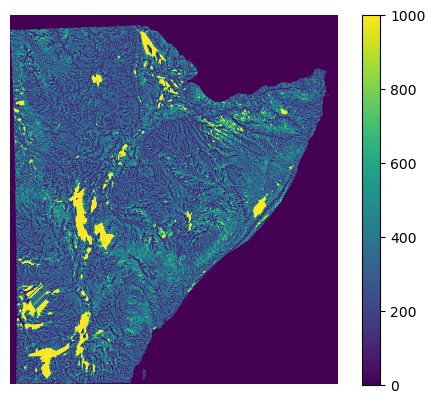

In [29]:
fname_parameter = "/home/cuwalid/training/historical/regional/model/input/HAD_riv_length_utm.asc"
plot_raster_file(fname_parameter, vmin=0.0, vmax=1000.0)

In [21]:
fname_parameter = "/home/cuwalid/training/historical/regional/model/input/HAD_rootdepth_utm_m.asc"

/tmp/ipykernel_1899156/94300322.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm_r', 12)


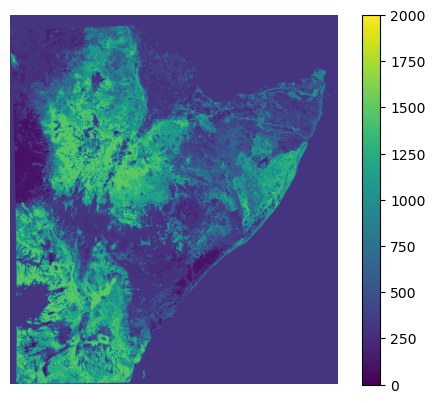

In [23]:
plot_raster_file(fname_parameter, vmin=0.0, vmax=2000)

Function described above required some information the is listed below, how to obtain is also explain below:

* list of precipitation dataset that will be used as forcing dataset for both precipitaiton (pre) and potential evapotranspiration (pet). They should include the path.
* name of model simulation files
* Name of the model for each simulation

Number of simulations

In [14]:
# list of number of files to process
#list_pre = range(0, 30), list_pet = range(0, 30)
#number of simulations
nsim = 30

list of precipitation dataset

In [15]:
# folder preipitation datasets
folder_datasets_pre = "/home/cuwalid/training/forecast/regional/dataset/pre/new_forecast/"#Forecast_PRE_HAD_ens_29_MAM_2022.nc"
#folder_datasets_pre = "D:/HAD/training/forecast/regional/datasets/pre/"
#fname_pre = [folder_datasets_pre+"Forecast_PRE_HAD_ens_"+str(isim)+"_MAM_2022.nc" for isim in range(nsim)]
fname_pre = [folder_datasets_pre+"2022_MAM_"+str(isim)+".nc" for isim in range(nsim)]


In [16]:
#fname_pre

List of potential evapotranspiration datasets

In [17]:
# folder potential evapotranspiration datasets
folder_datasets_pet = "/home/cuwalid/training/forecast/regional/dataset/pet/trial_5/"#Forecast_PET_HAD_ens_29_MAM_2022.nc"
#folder_datasets_pet = "D:/HAD/training/forecast/regional/datasets/pet/"
fname_pet = [folder_datasets_pet+"Forecast_PET_HAD_ens_"+str(isim)+"_MAM_2022.nc" for isim in range(nsim)]

In [18]:
#fname_pet

Depending on the number of datasets, the list of simulaitons required to cover all the posible combination of  forcing datasets could be large, therfore, only a sample of all posibles scenarions are chosen for the hydrological forecast.

selection of climate forecast

In [19]:
forcing_list = np.array(create_ensamble([fname_pet, fname_pre], nsamples=30))

In [20]:
forcing_list

array([['/home/cuwalid/training/forecast/regional/dataset/pet/trial_5/Forecast_PET_HAD_ens_19_MAM_2022.nc',
        '/home/cuwalid/training/forecast/regional/dataset/pre/new_forecast/2022_MAM_6.nc',
        ''],
       ['/home/cuwalid/training/forecast/regional/dataset/pet/trial_5/Forecast_PET_HAD_ens_15_MAM_2022.nc',
        '/home/cuwalid/training/forecast/regional/dataset/pre/new_forecast/2022_MAM_13.nc',
        ''],
       ['/home/cuwalid/training/forecast/regional/dataset/pet/trial_5/Forecast_PET_HAD_ens_12_MAM_2022.nc',
        '/home/cuwalid/training/forecast/regional/dataset/pre/new_forecast/2022_MAM_18.nc',
        ''],
       ['/home/cuwalid/training/forecast/regional/dataset/pet/trial_5/Forecast_PET_HAD_ens_25_MAM_2022.nc',
        '/home/cuwalid/training/forecast/regional/dataset/pre/new_forecast/2022_MAM_2.nc',
        ''],
       ['/home/cuwalid/training/forecast/regional/dataset/pet/trial_5/Forecast_PET_HAD_ens_2_MAM_2022.nc',
        '/home/cuwalid/training/forecast/re

Model list simulations:

Specifiy the list of model names and the name of model simulatio files

In [21]:
# Model file names
#local_directory = "/home/<username>/training/forecast/regional/model/" #D:/HAD/training/regional/model/"
local_directory = "/home/aquichimbo/training/forecast/regional/model/" #D:/HAD/training/regional/model/"
#local_directory = "/home/cuwalid/training/forecast/regional/" #D:/HAD/training/regional/model/"
#local_directory = "D:/HAD/model/icpac/" #D:/HAD/training/regional/model/"
fsim_input_file = local_directory + "HAD_IMERGba_input_MAM_forecast_0_2022.dmp"#"HAD_IMERG_input_sim_cuwalid.dmp"
fsim_setting_file = local_directory + "HAD_IMERGba_par_setting_0_2022.dwapm"#"HAD_IMERG_par_setting.dwapm"

# model name list of new simulation files
mname = ["MAM_2022_realization_test_"+str(isim) for isim in range(30)]
#fsim_forecasting = ["D:/HAD/training/forecast/regional/HAD_IMERG_input_sim_"+str(isim)+".dmp" for isim in range(30)]
#fsim_forecasting = ["D:\HAD\model\icpac\HAD_IMERGba_input_MAM_forecast_tests_"+str(isim)+"_2022.dmp" for isim in range(30)]
#fsim_forecasting = ["/home/cuwalid/training/forecast/regional/model/HAD_IMERGba_input_MAM_forecast_tests_"+str(isim)+"_2022.dmp" for isim in range(30)]
#fsim_forecasting = ["/home/<username>/training/forecast/regional/model/HAD_IMERGba_input_MAM_forecast_test_"+str(isim)+"_2022.dmp" for isim in range(30)]
fsim_forecasting = ["/home/aquichimbo/training/forecast/regional/model/HAD_IMERGba_input_MAM_forecast_test_"+str(isim)+"_2022.dmp" for isim in range(30)]

Generate simulation files

In [22]:
for ifsim_forecasting, imname, ifname_pre, ifname_pet in zip(fsim_forecasting, mname, forcing_list[:,1], forcing_list[:,0]):
    write_dryp_sim_file_forecasting(fsim_input_file,
                                    newfname_input=ifsim_forecasting,
                                    mname=imname,
                                    dataset_pre=ifname_pre, dataset_pet=ifname_pet,
                                    start_date="2022 03 01", end_date="2022 05 31",
                                    create_setting_file=False
                                   )

/tmp/ipykernel_1821555/2269932685.py:43: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  f.drylandmodel[1] = mname
/tmp/ipykernel_1821555/2269932685.py:46: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are set

### 4.2. Prepare multiple simulation on HPC

Run simulation on the backgound in linux. Uncoment lines to show results.

In [3]:
fsim_forecasting_list = ["HAD_IMERGba_input_MAM_forecast_test_"+str(isim)+"_2022.dmp" for isim in range(30)]

In [1]:
fsim_forecasting_list = ["HAD_IMERGba_input_MAM_forecast_test_"+str(isim)+"_2022.dmp" for isim in [0,3]]

In [4]:
for ifsim_forecasting in fsim_forecasting_list:
    #print("nohup python run_model_input.py /home/cuwalid/training/forecast/regional/model/"+ifsim_forecasting+" &")
    print("nohup python run_model_input.py /home/aquichimbo/training/forecast/regional/model/"+ifsim_forecasting+" &")

nohup python run_model_input.py /home/aquichimbo/training/forecast/regional/model/HAD_IMERGba_input_MAM_forecast_test_0_2022.dmp &
nohup python run_model_input.py /home/aquichimbo/training/forecast/regional/model/HAD_IMERGba_input_MAM_forecast_test_1_2022.dmp &
nohup python run_model_input.py /home/aquichimbo/training/forecast/regional/model/HAD_IMERGba_input_MAM_forecast_test_2_2022.dmp &
nohup python run_model_input.py /home/aquichimbo/training/forecast/regional/model/HAD_IMERGba_input_MAM_forecast_test_3_2022.dmp &
nohup python run_model_input.py /home/aquichimbo/training/forecast/regional/model/HAD_IMERGba_input_MAM_forecast_test_4_2022.dmp &
nohup python run_model_input.py /home/aquichimbo/training/forecast/regional/model/HAD_IMERGba_input_MAM_forecast_test_5_2022.dmp &
nohup python run_model_input.py /home/aquichimbo/training/forecast/regional/model/HAD_IMERGba_input_MAM_forecast_test_6_2022.dmp &
nohup python run_model_input.py /home/aquichimbo/training/forecast/regional/model/H

Create slurm files for each simulations


Run all simulation by subnniting all jobs

### 4.3. Understanding hydrological outputs

In [1]:
# Import libraries from local repository
import sys
#sys.path.append('C:/Users/Edisson/Documents/GitHub/DRYPv2.0.1')
sys.path.append('/home/cuwalid/CUWALID/DRYP/')

import tools.DRYP_pptools as pptools

# Import general libraries
import matplotlib.pyplot as plt
import xarray as xr

Explore the diferent format of model outputs, donwload one realization from the server all variables included on the outputs.

Note the DRYP output include the following formats

* Comma delimited files (.csv) to store time series,
* netCDF files (.nc) to store gridded output datasets, and
* ascii raster files (.asc) to store hydrological states for initial condions

**NOTE**: Before you start, please change the path to access the following directories:

#### Please, download one simulation from the ICPAC server for the following examples

In [2]:
#training_general_path = "D:/HAD/training/"
#regional_path = "D:/HAD/training/regional/"
#basin_path = "D:/HAD/training/basin/"


In [20]:
#fname_nc = "/home/cuwalid/training/forecast/regional/outputs/MAM_2022_realization_0_grid.nc"
fname_nc = "/shared/training/forecast/regional/outputs/MAM_2022_realization_test_20_grid.nc"
#fname_nc = "D:/HAD/output/MAM_2022_realization_1_grid.nc"
#fname_nc = basin_path + "output/Tana_IMcal_sim33_grid.nc"
#fname_output = basin_path + "postpp/Tana_IMcal_sim33_grid_season.nc"

In [21]:
#pptools.calculate_seasonal_average_from_netCDF(fname_nc, season="OND", fname_out=fname_output)

In [22]:
data = xr.open_dataset(fname_nc)['pre']

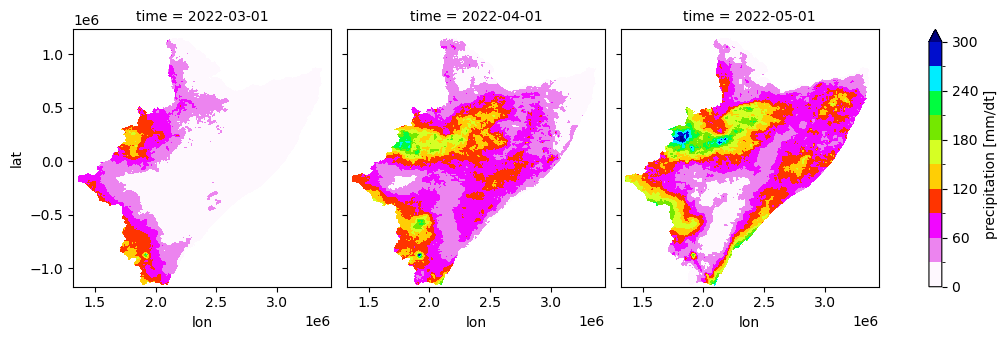

In [23]:
#data.plot(x="lon", y="lat", col="time")
data.plot(x="lon", y="lat", col="time", robust=False, cmap='gist_ncar_r', levels=11, figsize=(11,3.5), vmin=0, vmax=300)

**TASK**: Plot other variables available on the model outputs:

Grided datasets store the following variables (names of variables are written in parenthesis):

*grid.nc files store the following variables

* Precipitaion (pre)
* Potential evapotranspiration (pet)
* Actual evapotranspiration (aet)
* soil water content (tht)
* Total groundwater recharge (rch)
* Water table elevation (wte)
* Groundwater discharge (gdh)
* Groundwater Evapotranspiration (egw)
* Streamflow (dis)
* Infiltration (inf)
* Runoff (run)
* Total water storage (twsc)

whereas *gridrp.nc files store the following variables
* Transmission losses (tls)
* Focused groundwater recharge (fch)
* soil water content riparian zone (tht)
* Riparian evapotranspiration (aet)